<a href="https://colab.research.google.com/github/gmihaila/stock_risk_prediction/blob/master/notebooks/stock2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project



The purpose of this project is to implement Stock2Vec. 
In Word2Vec the window for each word is the surrounding words. For Stock2Vec we pick the surrounding stocks for each stock.

CSCE 4930/5933: Special Topics - Deep Learning

### NOTE: 

</br>


### [Run in Google Colab](https://colab.research.google.com/drive/1eJEXi_grZDbYBPg7Anij9_DpG4xihjA3#offline=true&sandboxMode=true)

# Info


* Main Dataset: [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500)

* Download detailes for each company: [S&P 500 Companies with Financial Information](https://datahub.io/core/s-and-p-500-companies-financials#resource-s-and-p-500-companies-financials_zip)

Stock prices are flutuated in every day. So, in each day, put those stocks in order of price change to one sentence. Then, with certain window size, each stock will show up with highly related stock frequently, because they tend to move their prices together. Source: [stock2vec repo](https://github.com/kh-kim/stock2vec)


Other links:

* [predicting-stock-price-machine-learningnd-deep-learning-techniques-python/](https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/)

# Kaggle Setup

In [0]:
!pip install -q kaggle
# get kaggle token
!wget -q https://www.dropbox.com/s/1b8516ptp5eao99/kaggle.json
# Ensure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Download Dataset

In [0]:
!kaggle datasets download -d camnugent/sandp500
!mkdir -p /content/stocks_data
!unzip -q -n /content/sandp500.zip -d /content/stocks_data/
!wget -q -nc https://datahub.io/core/s-and-p-500-companies-financials/r/constituents.csv
!ls

 78% 15.0M/19.3M [00:00<00:00, 52.7MB/s]
100% 19.3M/19.3M [00:00<00:00, 76.4MB/s]
constituents.csv  kaggle.json  sample_data  sandp500.zip  stocks_data


# Imports

In [0]:
import os
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import pandas as pd
import operator
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import gc


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Helper Functions

In [0]:
def encode_dataframe(data_frame, target_column='symbol', split_reference='year'):
  target_encoder = LabelEncoder()
  encoded_dataframe = pd.DataFrame()

  for column in data_frame.columns.values:
    if column in data_frame.columns.values[:13]:
      encoded_dataframe["%s_encoded"%column] = LabelEncoder().fit_transform(data_frame[column])
    else:
      if column == target_column:
        encoded_dataframe["%s_id"%column] = target_encoder.fit_transform(data_frame[target_column])
      encoded_dataframe[column] = data_frame[column]

  # add split_reference column for split
  encoded_dataframe[split_reference] = data_frame[split_reference]

  return encoded_dataframe, target_encoder


def dummy_encode_dataframe(data_frame, avoid_columns, dummy_columns):
  result_df = pd.DataFrame()
  for column in data_frame.columns.values:
    if column in avoid_columns:
      # skip columns
      continue
    elif column in dummy_columns:
      # dummy encode column
      dummy_df = pd.get_dummies(data_frame[column])
      # add each dummy column
      for dummy in dummy_df.columns.values:
        dummy_column = "%s_%s" % (column, dummy)
        result_df[dummy_column] = dummy_df[dummy]
    else:
      # add normal column
      result_df[column] = data_frame[column]

  return result_df


def tf_dataloader(data_frame, stock_symbol, stock_features, target, dtype='float32', buffer_size=1000, batch_size=32):
  # create numpy arrays
  stock_symbol_array = data_frame[stock_symbol].to_numpy(dtype=dtype)
  stock_symbol_array = stock_symbol_array.reshape((stock_symbol_array.shape[0],1))

  stock_features_array = data_frame[stock_features].to_numpy(dtype=dtype)
  target_array = data_frame[target].to_numpy(dtype=dtype)

  # create tf dataloader
  tf_dataset = tf.data.Dataset.from_tensor_slices(tensors=((stock_symbol_array, stock_features_array), target_array))
  tf_dataset = tf_dataset.shuffle(buffer_size).batch(batch_size)
  return tf_dataset


def build_model(first_input_shape, second_input_shape, embedding_size, vocabulary_size, use_optimizer='adam', use_loss='mean_squared_error', use_metrics=[]):
  # deal with first data part
  first_input_layer = tf.keras.layers.Input(shape=[first_input_shape], name='first_input')
  embedding_layer = tf.keras.layers.Embedding(vocabulary_size, embedding_size, name='embedding')(first_input_layer)
  average_layer = tf.keras.layers.GlobalAveragePooling1D(name='average')(embedding_layer)
  # deal with second data part
  second_input_layer = tf.keras.layers.Input(shape=[second_input_shape], name='second_input')
  # merge features
  merge_features_layer = tf.keras.layers.concatenate([average_layer, second_input_layer], name='merge_features')
  # predict
  predict_layer = tf.keras.layers.Dense(1, activation='linear', name='predict')(merge_features_layer)
  # build model
  tf_model = tf.keras.Model(inputs=[first_input_layer, second_input_layer], outputs=predict_layer)
  # compile model
  tf_model.compile(optimizer=use_optimizer,loss=use_loss, metrics=use_metrics)
  return tf_model


def plot_history(train_history, parameters_pairs, with_inch=20, height_inch=5, subtitle=''):
  n_plots = len(parameters_pairs)
  fig, axes = plt.subplots(1, n_plots)
  epochs = train_history.epoch
  fig.suptitle(subtitle)

  for use_axe, parameters in zip(axes, parameters_pairs):
    use_axe.set_title('Training and validation %s'%parameters[0])
    use_axe.set_xlabel('Epochs')
    use_axe.set_ylabel('Loss')

    train_parameter = train_history.history[parameters[0]]
    valid_parameter = train_history.history[parameters[1]]
    use_axe.plot(epochs, train_parameter, 'bo', label='Training %s'%parameters[0])
    use_axe.plot(epochs, valid_parameter, 'b', label='Validation %s'%parameters[1])
    use_axe.legend()
    use_axe.grid()
    use_axe.set_xticks(epochs)

  fig.set_size_inches(with_inch, height_inch)
  plt.show()
  return


def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot', magnify=2):
  pca_cuml = PCA(n_components=n_components,
                   random_state=random_state)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
    cluster_plot.savefig("pca_plot.png")
  return reduced_features


def get_tf_embeddings(tf_model, emb_layer):
  return tf_model.layers[emb_layer].get_weights()[0]


def sort_dict(mydict, reversed=False):
  return sorted(mydict.items(), key=operator.itemgetter(1), reverse=reversed)

# Prep Data

## Read Data

In [0]:
# Companies description
desc_df = pd.read_csv('/content/constituents.csv')
print('\nCompanies Details')
print(desc_df.head())

# stocks details
stocks_df = pd.read_csv('/content/stocks_data/all_stocks_5yr.csv', parse_dates=['date'])
print('\nCompanies Stocks')
print(stocks_df.head())

# dicitonary for companies name and sector
companies_names = {symbol:name for symbol, name in desc_df[['Symbol', 'Name']].values}
companies_sector = {symbol:sector for symbol, sector in desc_df[['Symbol', 'Sector']].values}
sector_idx = {sector:idx for idx, sector in enumerate(set(desc_df['Sector'].values))}
idx_sector = {idx:sector for idx, sector in enumerate(set(desc_df['Sector'].values))}


Companies Details
  Symbol                 Name                  Sector
0    MMM           3M Company             Industrials
1    AOS      A.O. Smith Corp             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV          AbbVie Inc.             Health Care
4    ACN        Accenture plc  Information Technology

Companies Stocks
        date   open   high    low  close    volume Name
0 2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1 2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2 2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3 2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4 2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


## New Data Frame using Date Features

In [0]:
dataset_df = pd.DataFrame()
dataset_df['year'] = stocks_df['date'].dt.year
dataset_df['month'] = stocks_df['date'].dt.month
dataset_df['day'] = stocks_df['date'].dt.day
dataset_df['weekday'] = stocks_df['date'].dt.dayofweek
dataset_df['weekofyear'] = stocks_df['date'].dt.weekofyear
dataset_df['dayofyear'] = stocks_df['date'].dt.dayofyear
dataset_df['days_in_month'] = stocks_df['date'].dt.days_in_month
dataset_df['is_leap_year'] = stocks_df['date'].dt.is_leap_year
dataset_df['is_month_start'] = stocks_df['date'].dt.is_month_start
dataset_df['is_month_end'] = stocks_df['date'].dt.is_month_end
dataset_df['is_quarter_start'] = stocks_df['date'].dt.is_quarter_start
dataset_df['is_quarter_end'] = stocks_df['date'].dt.is_quarter_end
dataset_df['is_year_start'] = stocks_df['date'].dt.is_year_start
dataset_df['open'] = stocks_df['open']
dataset_df['high'] = stocks_df['high']
dataset_df['low'] = stocks_df['low']
dataset_df['close'] = stocks_df['close']
dataset_df['symbol'] = stocks_df['Name']
dataset_df['name'] = [companies_names[symbol] for symbol in stocks_df['Name'].values]
dataset_df['sector'] = [companies_sector[symbol] for symbol in stocks_df['Name'].values]

dataset_df.head()

,year,month,day,weekday,weekofyear,dayofyear,days_in_month,is_leap_year,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,open,high,low,close,symbol,name,sector
0,2013,2,8,4,6,39,28,False,False,False,False,False,False,15.07,15.12,14.63,14.75,AAL,American Airlines Group,Industrials
1,2013,2,11,0,7,42,28,False,False,False,False,False,False,14.89,15.01,14.26,14.46,AAL,American Airlines Group,Industrials
2,2013,2,12,1,7,43,28,False,False,False,False,False,False,14.45,14.51,14.10,14.27,AAL,American Airlines Group,Industrials
3,2013,2,13,2,7,44,28,False,False,False,False,False,False,14.30,14.94,14.25,14.66,AAL,American Airlines Group,Industrials
4,2013,2,14,3,7,45,28,False,False,False,False,False,False,14.94,14.96,13.16,13.99,AAL,American Airlines Group,Industrials


## Encode Data Frame Values

In [0]:
encoded_dataframe, stockid_encoder = encode_dataframe(data_frame=dataset_df, target_column='symbol', split_reference='year')

# get each stock sector
sotcks_sectors_ids = [sector_idx[companies_sector[stock_symbol]] for stock_symbol in stockid_encoder.classes_]

encoded_dataframe.head()

,year_encoded,month_encoded,day_encoded,weekday_encoded,weekofyear_encoded,dayofyear_encoded,days_in_month_encoded,is_leap_year_encoded,is_month_start_encoded,is_month_end_encoded,is_quarter_start_encoded,is_quarter_end_encoded,is_year_start_encoded,open,high,low,close,symbol_id,symbol,name,sector,year
0,0,1,7,4,5,37,0,0,0,0,0,0,0,15.07,15.12,14.63,14.75,1,AAL,American Airlines Group,Industrials,2013
1,0,1,10,0,6,40,0,0,0,0,0,0,0,14.89,15.01,14.26,14.46,1,AAL,American Airlines Group,Industrials,2013
2,0,1,11,1,6,41,0,0,0,0,0,0,0,14.45,14.51,14.10,14.27,1,AAL,American Airlines Group,Industrials,2013
3,0,1,12,2,6,42,0,0,0,0,0,0,0,14.30,14.94,14.25,14.66,1,AAL,American Airlines Group,Industrials,2013
4,0,1,13,3,6,43,0,0,0,0,0,0,0,14.94,14.96,13.16,13.99,1,AAL,American Airlines Group,Industrials,2013


## Dummy Encode Data Frame Encoded Values

* year 6
* month 12
* day 31
* weekday 5
* weekofyear 53
* dayofyear 362
* days_in_month 4


In [0]:
dummy_encoded_dataframe = dummy_encode_dataframe(data_frame=encoded_dataframe,
                                                 avoid_columns=['weekofyear_encoded', 'dayofyear_encoded'], 
                                                 dummy_columns=encoded_dataframe.columns[:7])
dummy_encoded_dataframe.head()

,year_encoded_0,year_encoded_1,year_encoded_2,year_encoded_3,year_encoded_4,year_encoded_5,month_encoded_0,month_encoded_1,month_encoded_2,month_encoded_3,month_encoded_4,month_encoded_5,month_encoded_6,month_encoded_7,month_encoded_8,month_encoded_9,month_encoded_10,month_encoded_11,day_encoded_0,day_encoded_1,day_encoded_2,day_encoded_3,day_encoded_4,day_encoded_5,day_encoded_6,day_encoded_7,day_encoded_8,day_encoded_9,day_encoded_10,day_encoded_11,day_encoded_12,day_encoded_13,day_encoded_14,day_encoded_15,day_encoded_16,day_encoded_17,day_encoded_18,day_encoded_19,day_encoded_20,day_encoded_21,day_encoded_22,day_encoded_23,day_encoded_24,day_encoded_25,day_encoded_26,day_encoded_27,day_encoded_28,day_encoded_29,day_encoded_30,weekday_encoded_0,weekday_encoded_1,weekday_encoded_2,weekday_encoded_3,weekday_encoded_4,days_in_month_encoded_0,days_in_month_encoded_1,days_in_month_encoded_2,days_in_month_encoded_3,is_leap_year_encoded,is_month_start_encoded,is_month_end_encoded,is_quarter_start_encoded,is_quarter_end_encoded,is_year_start_encoded,open,high,low,close,symbol_id,symbol,name,sector,year
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,15.07,15.12,14.63,14.75,1,AAL,American Airlines Group,Industrials,2013
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,14.89,15.01,14.26,14.46,1,AAL,American Airlines Group,Industrials,2013
2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,14.45,14.51,14.10,14.27,1,AAL,American Airlines Group,Industrials,2013
3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,14.30,14.94,14.25,14.66,1,AAL,American Airlines Group,Industrials,2013
4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,14.94,14.96,13.16,13.99,1,AAL,American Airlines Group,Industrials,2013


## Train - Validation - Test

* Use leates year for test [2018].
* Use [2017] for validation.
* Use remaining years for train.


In [0]:
train_df = dummy_encoded_dataframe[dummy_encoded_dataframe['year'] < 2017]
valid_df = dummy_encoded_dataframe[dummy_encoded_dataframe['year'] == 2017]
test_df = dummy_encoded_dataframe[dummy_encoded_dataframe['year'] == 2018]

print('Train size: %d\nValid size: %d\nTest size : %d' % (len(train_df), len(valid_df), len(test_df)))

Train size: 479878
Valid size: 126032
Test size : 13130


# Tensorflow Modeling

## Tensorflow Dataset

In [0]:
feature_columns = dummy_encoded_dataframe.columns.values[:-9]
# create tesnorflow datasets
train_dataset = tf_dataloader(data_frame=train_df, stock_symbol='symbol_id', stock_features=feature_columns, target='close', dtype='float32', batch_size=32)
valid_dataset = tf_dataloader(data_frame=valid_df, stock_symbol='symbol_id', stock_features=feature_columns, target='close', dtype='float32', batch_size=32)
test_dataset = tf_dataloader(data_frame=test_df, stock_symbol='symbol_id', stock_features=feature_columns, target='close', dtype='float32', batch_size=32)

## Find Best Model

Optimizer: adam Loss: mean_squared_error Embedding size: 10
Epoch 1/10
14997/14997 [==============================] - 24s 2ms/step - loss: 9302.2441 - mae: 45.0739 - mse: 9302.7324 - val_loss: 15388.6133 - val_mae: 47.7453 - val_mse: 15390.4424
Epoch 2/10
14997/14997 [==============================] - 24s 2ms/step - loss: 5334.7969 - mae: 23.8342 - mse: 5335.0850 - val_loss: 11865.3496 - val_mae: 37.3947 - val_mse: 11866.7607
Epoch 3/10
14997/14997 [==============================] - 24s 2ms/step - loss: 3652.1873 - mae: 16.3027 - mse: 3652.3835 - val_loss: 9830.6729 - val_mae: 38.1986 - val_mse: 9831.7969
Epoch 4/10
14997/14997 [==============================] - 24s 2ms/step - loss: 2589.6848 - mae: 14.0925 - mse: 2589.8230 - val_loss: 8192.0244 - val_mae: 37.9648 - val_mse: 8192.9688
Epoch 5/10
14997/14997 [==============================] - 24s 2ms/step - loss: 1836.1827 - mae: 12.9938 - mse: 1836.2817 - val_loss: 6944.9312 - val_mae: 37.8623 - val_mse: 6945.7134
Epoch 6/10
14997/1499

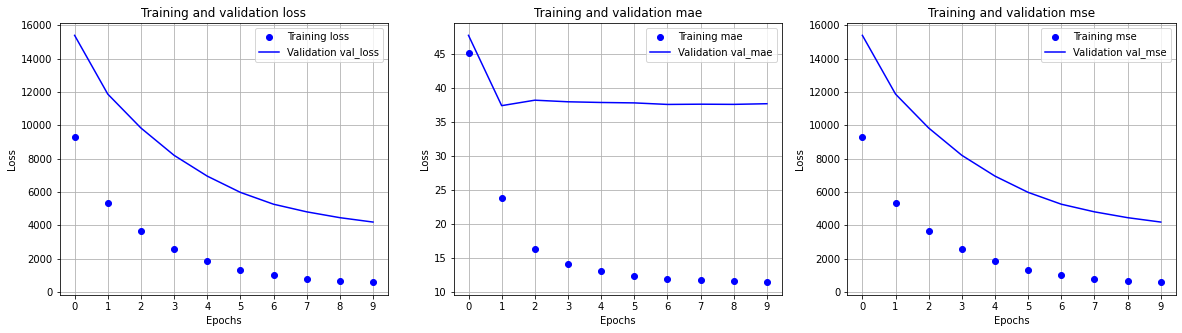

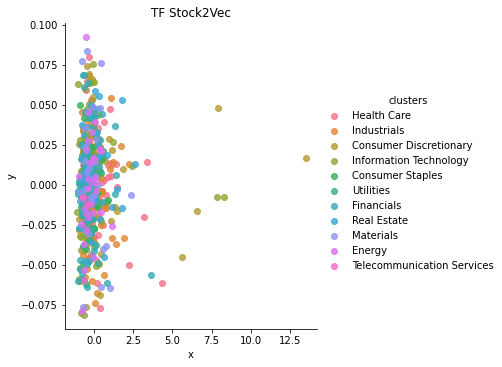


Optimizer: adam Loss: mean_squared_error Embedding size: 50
Epoch 1/10
14997/14997 [==============================] - 26s 2ms/step - loss: 7684.8955 - mae: 34.0414 - mse: 7685.3071 - val_loss: 11930.4092 - val_mae: 41.4169 - val_mse: 11931.8564
Epoch 2/10
14997/14997 [==============================] - 26s 2ms/step - loss: 3321.2273 - mae: 18.4934 - mse: 3321.4058 - val_loss: 7706.0273 - val_mae: 31.6668 - val_mse: 7706.9482
Epoch 3/10
14997/14997 [==============================] - 26s 2ms/step - loss: 1471.7441 - mae: 12.3644 - mse: 1471.8219 - val_loss: 5187.4624 - val_mae: 30.9867 - val_mse: 5188.0669
Epoch 4/10
14997/14997 [==============================] - 26s 2ms/step - loss: 811.4188 - mae: 11.3737 - mse: 811.4620 - val_loss: 3995.8098 - val_mae: 31.1301 - val_mse: 3996.2314
Epoch 5/10
14997/14997 [==============================] - 26s 2ms/step - loss: 560.9910 - mae: 11.0658 - mse: 561.0172 - val_loss: 3444.3276 - val_mae: 31.7085 - val_mse: 3444.7109
Epoch 6/10
14997/14997 [==

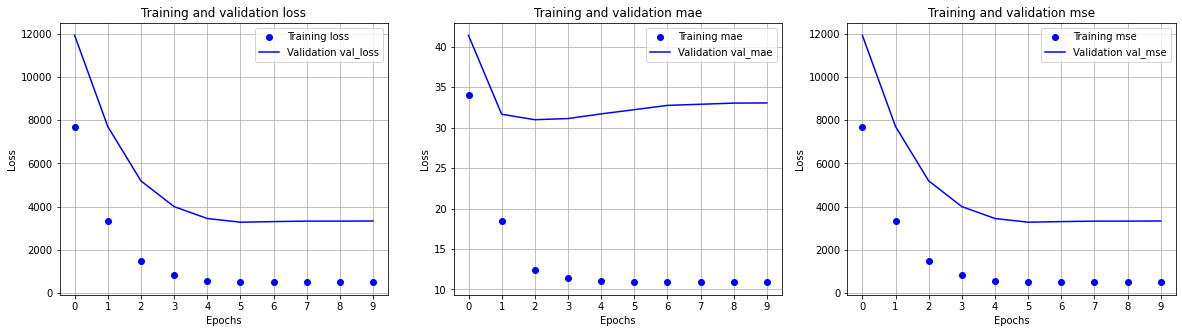

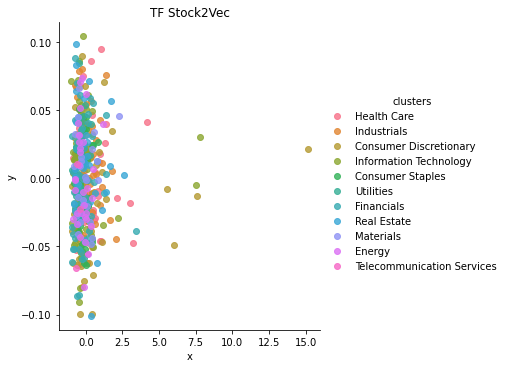


Optimizer: adam Loss: mean_squared_error Embedding size: 100
Epoch 1/10
14997/14997 [==============================] - 29s 2ms/step - loss: 6730.0752 - mae: 29.1168 - mse: 6730.4370 - val_loss: 10430.7139 - val_mae: 40.5479 - val_mse: 10432.0020
Epoch 2/10
14997/14997 [==============================] - 28s 2ms/step - loss: 2429.3931 - mae: 16.2238 - mse: 2429.5242 - val_loss: 5827.0986 - val_mae: 28.7490 - val_mse: 5827.7949
Epoch 3/10
14997/14997 [==============================] - 29s 2ms/step - loss: 928.3640 - mae: 11.5696 - mse: 928.4130 - val_loss: 3808.7295 - val_mae: 28.7374 - val_mse: 3809.1414
Epoch 4/10
14997/14997 [==============================] - 29s 2ms/step - loss: 570.0535 - mae: 10.9746 - mse: 570.0816 - val_loss: 3186.9238 - val_mae: 29.7765 - val_mse: 3187.2722
Epoch 5/10
14997/14997 [==============================] - 28s 2ms/step - loss: 484.0297 - mae: 10.8124 - mse: 484.0555 - val_loss: 3085.3948 - val_mae: 30.9005 - val_mse: 3085.7202
Epoch 6/10
14997/14997 [===

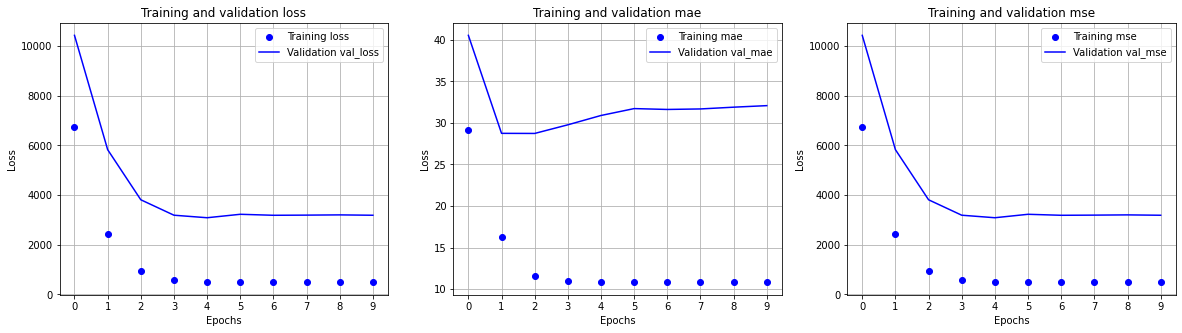

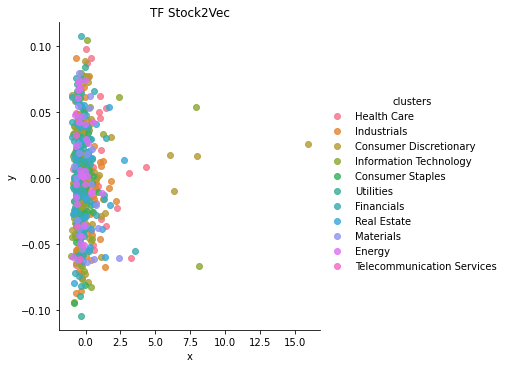


Optimizer: adam Loss: mean_absolute_percentage_error Embedding size: 10
Epoch 1/10
14997/14997 [==============================] - 26s 2ms/step - loss: 44.6364 - mae: 46.0386 - mse: 9486.3184 - val_loss: 40.6000 - val_mae: 47.6894 - val_mse: 15501.5879
Epoch 2/10
14997/14997 [==============================] - 25s 2ms/step - loss: 23.2426 - mae: 23.4213 - mse: 5951.7798 - val_loss: 32.4426 - val_mae: 39.5285 - val_mse: 12986.8291
Epoch 3/10
14997/14997 [==============================] - 25s 2ms/step - loss: 15.8829 - mae: 17.6551 - mse: 4541.6113 - val_loss: 35.5255 - val_mae: 40.1045 - val_mse: 11624.5801
Epoch 4/10
14997/14997 [==============================] - 25s 2ms/step - loss: 15.1646 - mae: 15.8859 - mse: 3694.9172 - val_loss: 34.4862 - val_mae: 38.4055 - val_mse: 10327.7227
Epoch 5/10
14997/14997 [==============================] - 26s 2ms/step - loss: 14.8866 - mae: 14.8242 - mse: 3049.2407 - val_loss: 34.3333 - val_mae: 37.3138 - val_mse: 9278.7188
Epoch 6/10
14997/14997 [====

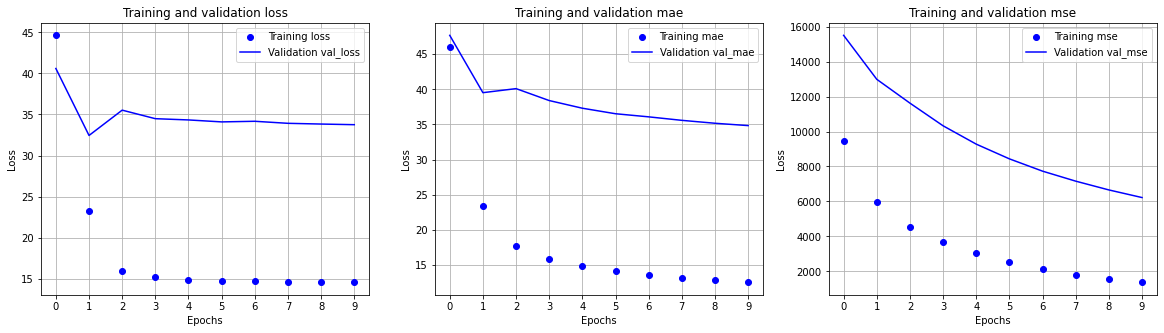

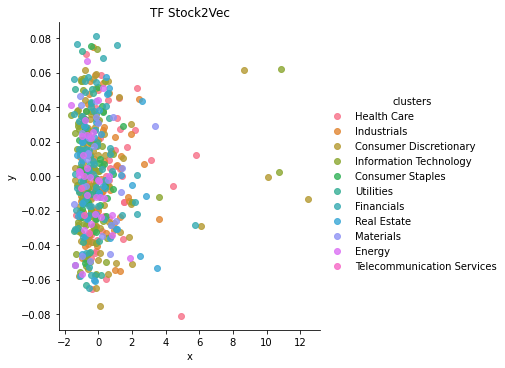


Optimizer: adam Loss: mean_absolute_percentage_error Embedding size: 50
Epoch 1/10
14997/14997 [==============================] - 27s 2ms/step - loss: 32.3863 - mae: 35.4605 - mse: 7950.1821 - val_loss: 42.4006 - val_mae: 40.8703 - val_mse: 12202.2236
Epoch 2/10
14997/14997 [==============================] - 26s 2ms/step - loss: 18.8388 - mae: 18.3103 - mse: 4374.1099 - val_loss: 29.9321 - val_mae: 35.2465 - val_mse: 10332.1035
Epoch 3/10
14997/14997 [==============================] - 27s 2ms/step - loss: 14.6782 - mae: 14.6324 - mse: 3024.9424 - val_loss: 32.8102 - val_mae: 36.9190 - val_mse: 9106.6211
Epoch 4/10
14997/14997 [==============================] - 26s 2ms/step - loss: 14.4538 - mae: 13.5645 - mse: 2298.7043 - val_loss: 32.1882 - val_mae: 35.3332 - val_mse: 7853.1587
Epoch 5/10
14997/14997 [==============================] - 26s 2ms/step - loss: 14.3777 - mae: 12.9366 - mse: 1819.9818 - val_loss: 32.1157 - val_mae: 34.5747 - val_mse: 6979.2461
Epoch 6/10
14997/14997 [======

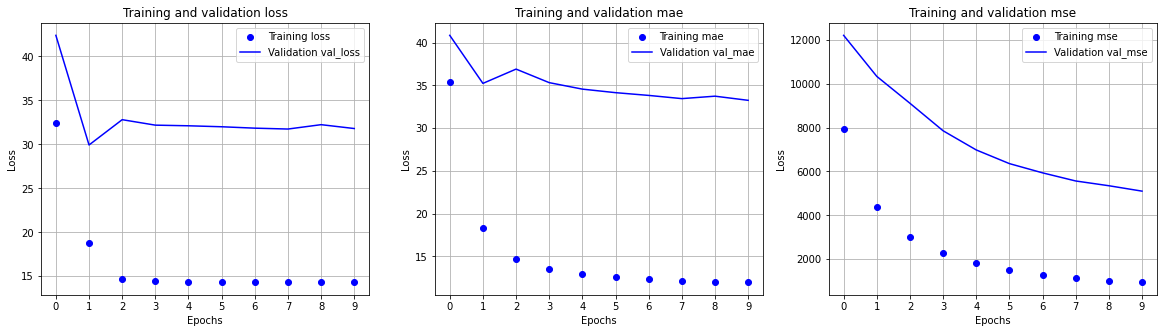

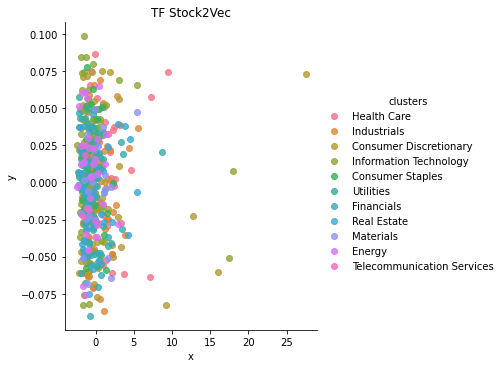


Optimizer: adam Loss: mean_absolute_percentage_error Embedding size: 100
Epoch 1/10
14997/14997 [==============================] - 29s 2ms/step - loss: 28.5049 - mae: 31.4273 - mse: 7233.1050 - val_loss: 38.1287 - val_mae: 37.8053 - val_mse: 11065.4707
Epoch 2/10
14997/14997 [==============================] - 29s 2ms/step - loss: 16.8845 - mae: 16.7653 - mse: 3820.0225 - val_loss: 28.4739 - val_mae: 33.5181 - val_mse: 9287.4766
Epoch 3/10
14997/14997 [==============================] - 29s 2ms/step - loss: 14.4131 - mae: 13.8115 - mse: 2524.4038 - val_loss: 31.8943 - val_mae: 36.0488 - val_mse: 8259.0078
Epoch 4/10
14997/14997 [==============================] - 30s 2ms/step - loss: 14.2148 - mae: 12.9354 - mse: 1901.8428 - val_loss: 31.7068 - val_mae: 35.0497 - val_mse: 7223.1191
Epoch 5/10
14997/14997 [==============================] - 29s 2ms/step - loss: 14.2129 - mae: 12.5629 - mse: 1573.2916 - val_loss: 31.3369 - val_mae: 34.0599 - val_mse: 6471.6504
Epoch 6/10
14997/14997 [======

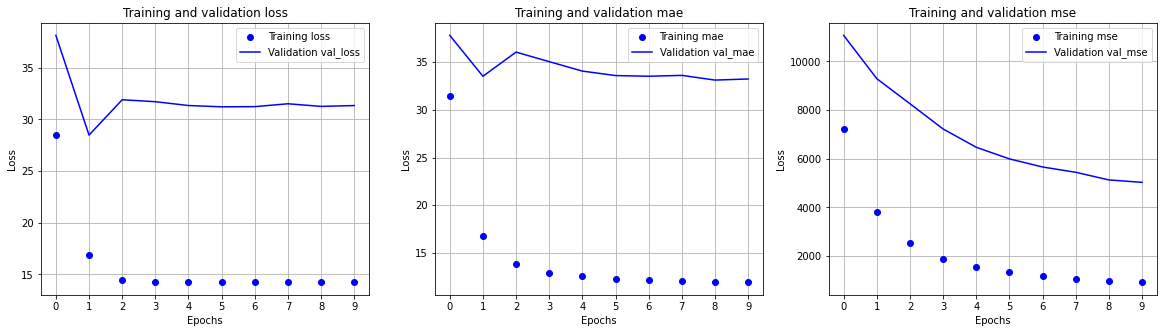

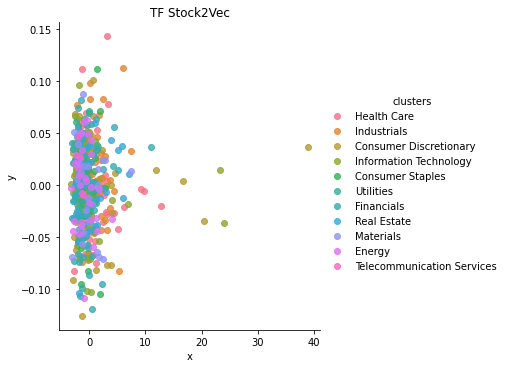


Optimizer: adam_1 Loss: mean_squared_error Embedding size: 10
Epoch 1/10
14997/14997 [==============================] - 24s 2ms/step - loss: 9387.1064 - mae: 45.5798 - mse: 9387.6123 - val_loss: 15606.5986 - val_mae: 48.4918 - val_mse: 15608.4619
Epoch 2/10
14997/14997 [==============================] - 24s 2ms/step - loss: 5504.8442 - mae: 24.5192 - mse: 5505.1421 - val_loss: 12230.4707 - val_mae: 38.2195 - val_mse: 12231.9482
Epoch 3/10
14997/14997 [==============================] - 25s 2ms/step - loss: 3913.8459 - mae: 16.8432 - mse: 3914.0564 - val_loss: 10393.6152 - val_mae: 39.0408 - val_mse: 10394.8691
Epoch 4/10
14997/14997 [==============================] - 24s 2ms/step - loss: 2950.8037 - mae: 14.5900 - mse: 2950.9607 - val_loss: 8995.1836 - val_mae: 38.7638 - val_mse: 8996.2002
Epoch 5/10
14997/14997 [==============================] - 25s 2ms/step - loss: 2273.2366 - mae: 13.5560 - mse: 2273.3572 - val_loss: 7924.9771 - val_mae: 38.6983 - val_mse: 7925.8843
Epoch 6/10
14997

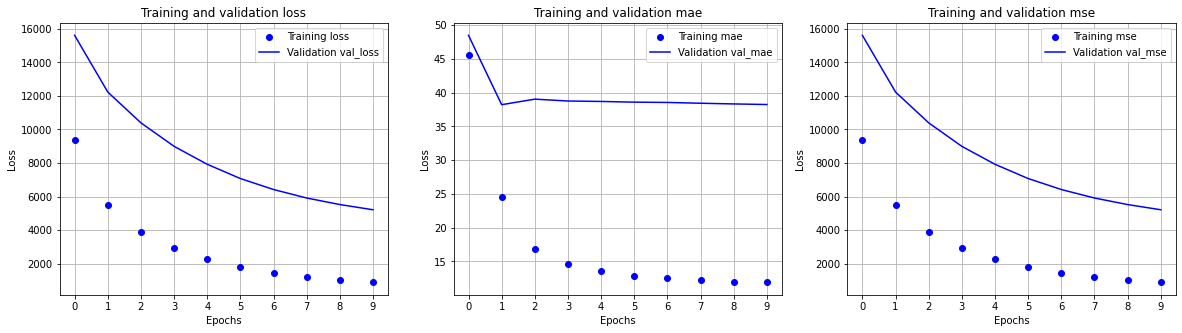

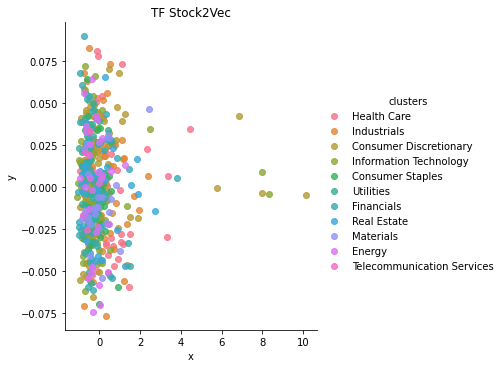


Optimizer: adam_1 Loss: mean_squared_error Embedding size: 50
Epoch 1/10
14997/14997 [==============================] - 25s 2ms/step - loss: 9133.0840 - mae: 44.0321 - mse: 9133.5615 - val_loss: 14417.1973 - val_mae: 44.1844 - val_mse: 14418.9785
Epoch 2/10
14997/14997 [==============================] - 25s 2ms/step - loss: 4814.7910 - mae: 21.3003 - mse: 4815.0488 - val_loss: 10588.4541 - val_mae: 33.0121 - val_mse: 10589.7441
Epoch 3/10
14997/14997 [==============================] - 25s 2ms/step - loss: 3114.8975 - mae: 15.1847 - mse: 3115.0642 - val_loss: 8464.7559 - val_mae: 33.1572 - val_mse: 8465.7910
Epoch 4/10
14997/14997 [==============================] - 25s 2ms/step - loss: 2091.5381 - mae: 13.1840 - mse: 2091.6511 - val_loss: 6882.8027 - val_mae: 32.7478 - val_mse: 6883.6162
Epoch 5/10
14997/14997 [==============================] - 25s 2ms/step - loss: 1442.2362 - mae: 12.2129 - mse: 1442.3126 - val_loss: 5750.6729 - val_mae: 32.5675 - val_mse: 5751.3545
Epoch 6/10
14997/1

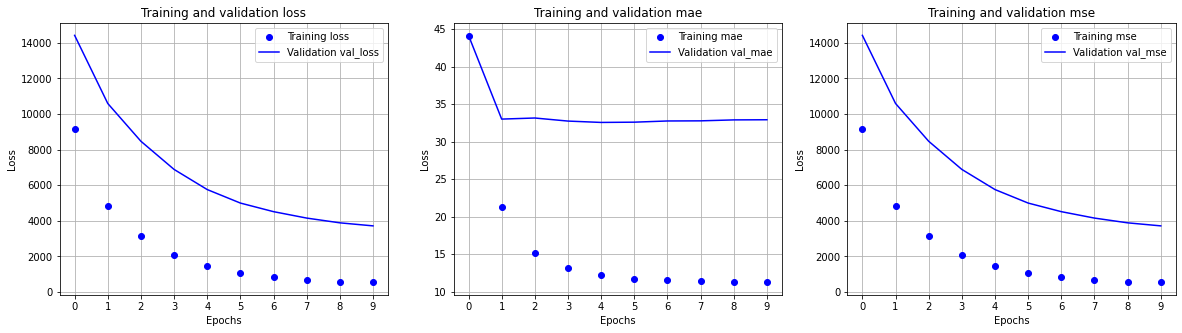

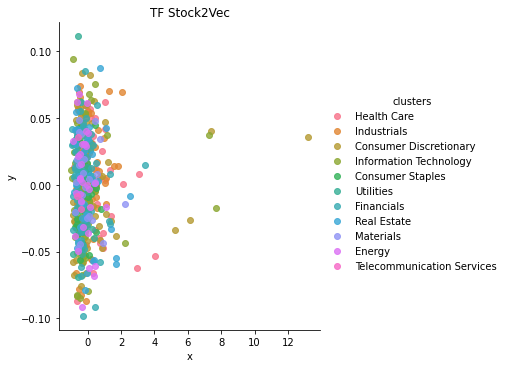


Optimizer: adam_1 Loss: mean_squared_error Embedding size: 100
Epoch 1/10
14997/14997 [==============================] - 27s 2ms/step - loss: 9514.4463 - mae: 47.1142 - mse: 9514.9590 - val_loss: 14689.1133 - val_mae: 44.9865 - val_mse: 14690.8740
Epoch 2/10
14997/14997 [==============================] - 28s 2ms/step - loss: 4849.0508 - mae: 21.0244 - mse: 4849.3120 - val_loss: 10530.2188 - val_mae: 32.1130 - val_mse: 10531.5107
Epoch 3/10
14997/14997 [==============================] - 27s 2ms/step - loss: 3097.4729 - mae: 15.2892 - mse: 3097.6401 - val_loss: 8269.9385 - val_mae: 31.7708 - val_mse: 8270.9316
Epoch 4/10
14997/14997 [==============================] - 27s 2ms/step - loss: 2033.9550 - mae: 13.1858 - mse: 2034.0629 - val_loss: 6619.9600 - val_mae: 31.1948 - val_mse: 6620.7534
Epoch 5/10
14997/14997 [==============================] - 27s 2ms/step - loss: 1378.6567 - mae: 12.1412 - mse: 1378.7307 - val_loss: 5451.3999 - val_mae: 30.8703 - val_mse: 5452.0342
Epoch 6/10
14997/

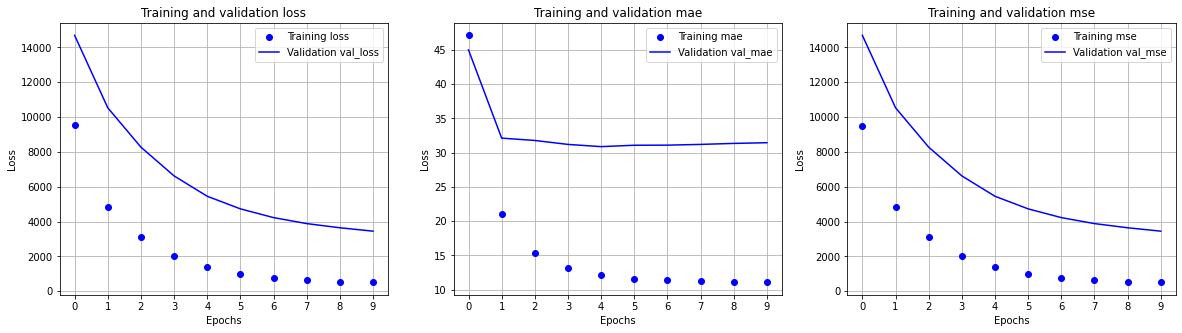

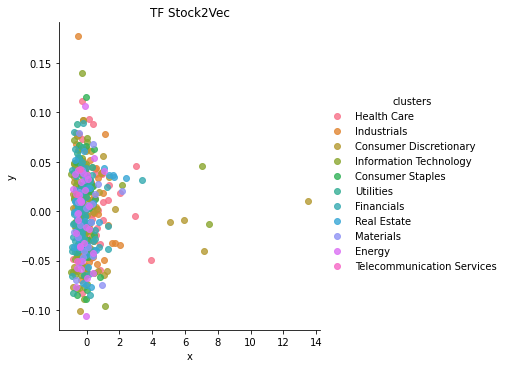


Optimizer: adam_1 Loss: mean_absolute_percentage_error Embedding size: 10
Epoch 1/10
14997/14997 [==============================] - 25s 2ms/step - loss: 72.2560 - mae: 64.2170 - mse: 11716.1152 - val_loss: 61.8472 - val_mae: 75.2952 - val_mse: 20898.1133
Epoch 2/10
14997/14997 [==============================] - 25s 2ms/step - loss: 42.7082 - mae: 44.2263 - mse: 9116.1084 - val_loss: 45.1358 - val_mae: 60.7542 - val_mse: 18353.1211
Epoch 3/10
14997/14997 [==============================] - 25s 2ms/step - loss: 28.3398 - mae: 32.9817 - mse: 7676.3994 - val_loss: 38.4098 - val_mae: 51.8841 - val_mse: 16483.5176
Epoch 4/10
14997/14997 [==============================] - 26s 2ms/step - loss: 20.9273 - mae: 26.1049 - mse: 6669.0566 - val_loss: 36.3209 - val_mae: 47.1820 - val_mse: 15157.0381
Epoch 5/10
14997/14997 [==============================] - 25s 2ms/step - loss: 18.0242 - mae: 22.3131 - mse: 5957.9326 - val_loss: 35.7441 - val_mae: 44.6604 - val_mse: 14204.1660
Epoch 6/10
14997/14997 [

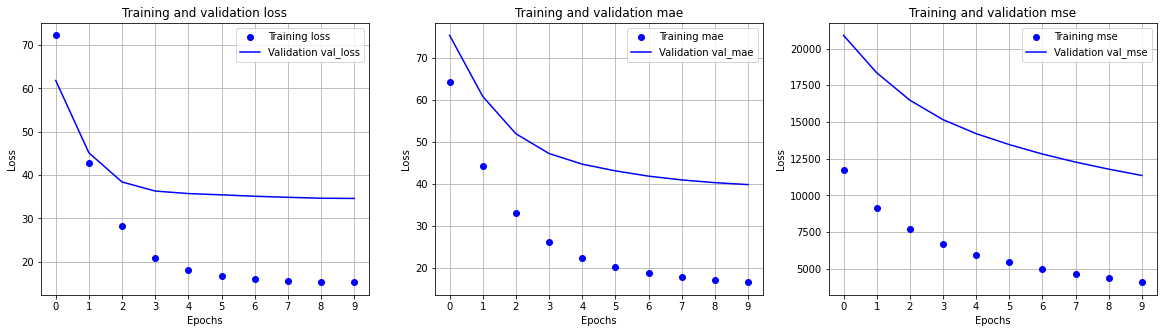

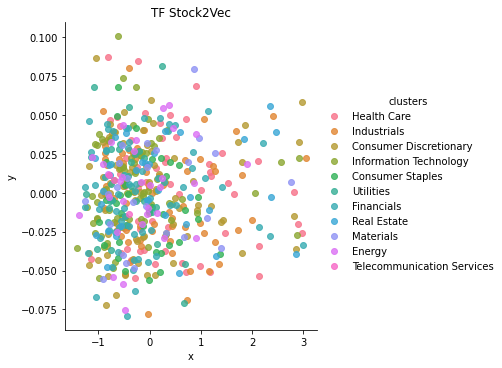


Optimizer: adam_1 Loss: mean_absolute_percentage_error Embedding size: 50
Epoch 1/10
14997/14997 [==============================] - 27s 2ms/step - loss: 69.5946 - mae: 62.7271 - mse: 11529.3857 - val_loss: 52.9228 - val_mae: 67.5380 - val_mse: 19575.0430
Epoch 2/10
14997/14997 [==============================] - 26s 2ms/step - loss: 30.8442 - mae: 34.5000 - mse: 7866.4805 - val_loss: 32.8107 - val_mae: 46.5522 - val_mse: 15639.1553
Epoch 3/10
14997/14997 [==============================] - 26s 2ms/step - loss: 19.3528 - mae: 23.4562 - mse: 6120.8511 - val_loss: 31.6667 - val_mae: 41.3738 - val_mse: 13749.0938
Epoch 4/10
14997/14997 [==============================] - 26s 2ms/step - loss: 16.4646 - mae: 19.3448 - mse: 5125.9746 - val_loss: 31.8210 - val_mae: 39.4622 - val_mse: 12518.5215
Epoch 5/10
14997/14997 [==============================] - 26s 2ms/step - loss: 15.5830 - mae: 17.4354 - mse: 4448.6211 - val_loss: 31.8789 - val_mae: 38.3027 - val_mse: 11567.3721
Epoch 6/10
14997/14997 [

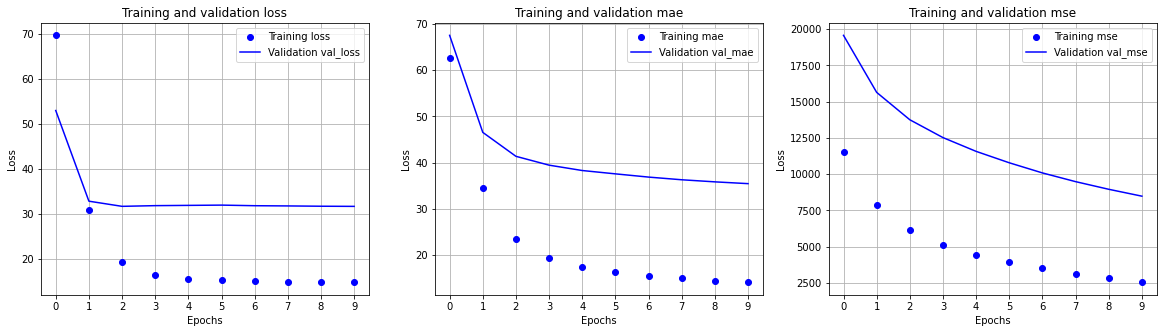

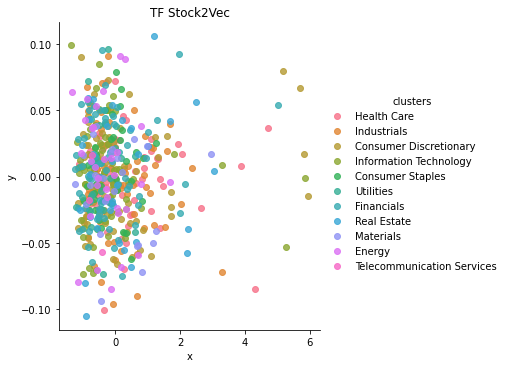


Optimizer: adam_1 Loss: mean_absolute_percentage_error Embedding size: 100
Epoch 1/10
14997/14997 [==============================] - 28s 2ms/step - loss: 68.4645 - mae: 62.0469 - mse: 11444.1650 - val_loss: 49.8036 - val_mae: 64.1871 - val_mse: 18989.5039
Epoch 2/10
14997/14997 [==============================] - 29s 2ms/step - loss: 27.8516 - mae: 31.5409 - mse: 7447.4600 - val_loss: 30.1692 - val_mae: 42.8360 - val_mse: 14823.1758
Epoch 3/10
14997/14997 [==============================] - 28s 2ms/step - loss: 18.1883 - mae: 21.6492 - mse: 5692.0049 - val_loss: 30.0980 - val_mae: 39.1786 - val_mse: 13024.8369
Epoch 4/10
14997/14997 [==============================] - 28s 2ms/step - loss: 15.9980 - mae: 18.2159 - mse: 4714.0220 - val_loss: 30.3417 - val_mae: 37.6184 - val_mse: 11773.8330
Epoch 5/10
14997/14997 [==============================] - 28s 2ms/step - loss: 15.3582 - mae: 16.6212 - mse: 4034.4868 - val_loss: 30.6142 - val_mae: 36.8478 - val_mse: 10817.3389
Epoch 6/10
14997/14997 

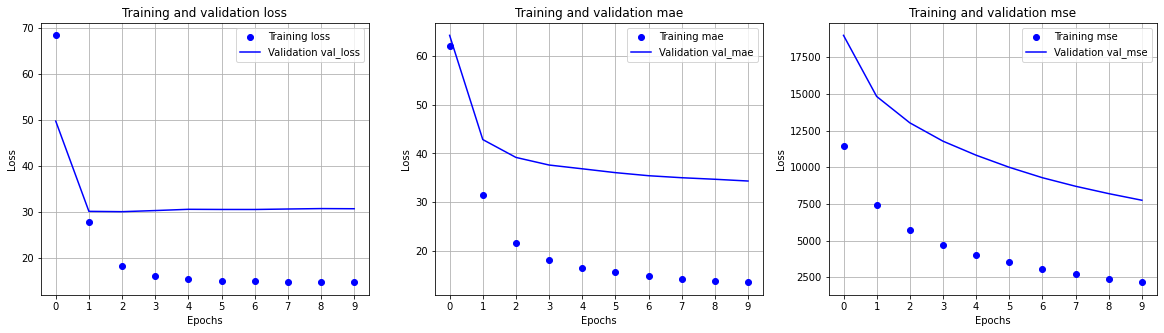

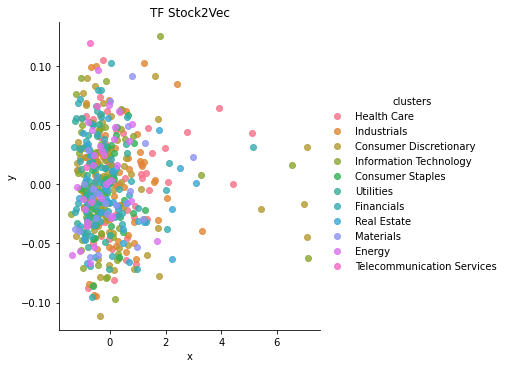


Optimizer: rmsp_1 Loss: mean_squared_error Embedding size: 10
Epoch 1/10
14997/14997 [==============================] - 23s 2ms/step - loss: 4257.0854 - mae: 18.3801 - mse: 4257.3149 - val_loss: 11696.1377 - val_mae: 56.2786 - val_mse: 11697.5254
Epoch 2/10
11957/14997 [======================>.......] - ETA: 3s - loss: 3924.4302 - mae: 21.3014 - mse: 3924.4302Buffered data was truncated after reaching the output size limit.

In [0]:
# parameters
n_stockids = len(stockid_encoder.classes_)
n_features = len(feature_columns)
# grid search parameters
optimizers = {'adam':'adam',
              'adam_1':tf.keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200),
              'rmsp_1':tf.keras.optimizers.RMSprop(0.009),
              'rmsp_2':tf.keras.optimizers.RMSprop(0.001)}
              
losses = ['mean_squared_error', 'mean_absolute_percentage_error']
embeddings_sizes = [10, 50, 100]


# callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# grid search
for name, optimizer in optimizers.items():
  for loss in losses:
    for embedding_size in embeddings_sizes:
      print('Optimizer: %s Loss: %s Embedding size: %s' % (name, loss, embedding_size))
      tmp_model = build_model(first_input_shape=1, 
                              second_input_shape=n_features, 
                              embedding_size=embedding_size, 
                              vocabulary_size=n_stockids, 
                              use_optimizer=optimizer, 
                              use_loss=loss,
                              use_metrics=['mae', 'mse'])
      # train model
      history = tmp_model.fit(train_dataset, 
                              validation_data=valid_dataset, 
                              epochs=10,
                              callbacks=[early_stop])
      # plot results
      plot_history(train_history=history,
                  parameters_pairs=[('loss', 'val_loss'), ('mae', 'val_mae'), ('mse', 'val_mse')])
      
      # get embeddings
      sotcks_tf_embeddings = get_tf_embeddings(tf_model=tmp_model, emb_layer=1)

      # plot embedding using PCA 2 components
      pca_reduction(features=sotcks_tf_embeddings, 
                    labels_values=sotcks_sectors_ids, 
                    n_components=2, 
                    random_state=20, 
                    label_decoder=idx_sector, title='TF Stock2Vec', magnify=1);
      # delete variables for next itteration
      del tmp_model, sotcks_tf_embeddings, history
      gc.collect()
      print()

## Build Final Model

We found best model using:
`Optimizer: adam_1 Loss: mean_absolute_percentage_error Embedding size: 10`

In [0]:
best_optimizer = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200)
best_loss = 'mean_absolute_percentage_error'
best_emb_size = 10

model = build_model(first_input_shape=1, 
                    second_input_shape=n_features, 
                    embedding_size=best_emb_size, 
                    vocabulary_size=n_stockids, 
                    use_optimizer=best_optimizer, 
                    use_loss=best_loss,
                    use_metrics=['mae', 'mse'])

model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        5050        first_input[0][0]                
__________________________________________________________________________________________________
average (GlobalAveragePooling1D (None, 10)           0           embedding[0][0]                  
__________________________________________________________________________________________________
second_input (InputLayer)       [(None, 64)]         0                                            
___________________________________________________________________________________________

## Train

Epoch 1/20
14997/14997 [==============================] - 27s 2ms/step - loss: 45.3702 - mae: 46.6473 - mse: 9549.2949 - val_loss: 40.8995 - val_mae: 48.4455 - val_mse: 15655.8896
Epoch 2/20
14997/14997 [==============================] - 26s 2ms/step - loss: 23.9864 - mae: 24.2778 - mse: 6107.5146 - val_loss: 32.0062 - val_mae: 39.9397 - val_mse: 13243.3857
Epoch 3/20
14997/14997 [==============================] - 33s 2ms/step - loss: 16.1377 - mae: 18.2083 - mse: 4745.0601 - val_loss: 35.5531 - val_mae: 40.5007 - val_mse: 11989.1553
Epoch 4/20
14997/14997 [==============================] - 27s 2ms/step - loss: 15.2907 - mae: 16.3671 - mse: 3961.9014 - val_loss: 34.7504 - val_mae: 39.1130 - val_mse: 10866.4551
Epoch 5/20
14997/14997 [==============================] - 27s 2ms/step - loss: 15.0724 - mae: 15.3729 - mse: 3389.5610 - val_loss: 34.4118 - val_mae: 37.9327 - val_mse: 9933.6680
Epoch 6/20
14997/14997 [==============================] - 27s 2ms/step - loss: 14.9288 - mae: 14.6573

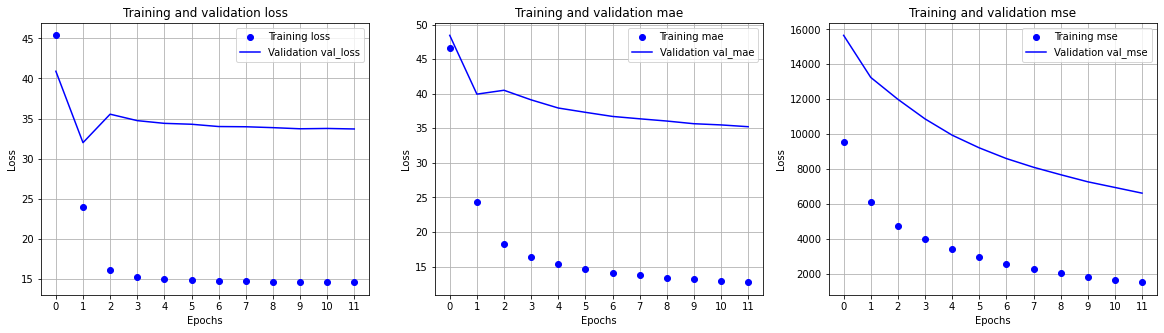

In [0]:
history = model.fit(train_dataset, 
                    validation_data=valid_dataset, 
                    epochs=20,
                    callbacks=[early_stop])

plot_history(train_history=history,
             parameters_pairs=[('loss', 'val_loss'), ('mae', 'val_mae'), ('mse', 'val_mse')])

## Evaluate

In [0]:
loss, mae, mse = model.evaluate(test_dataset, verbose=2)
test_predictions = model.predict(test_dataset).flatten()

print("Testing set Mean Abs Error Closing Price: {:5.2f} ".format(mae))

411/411 - 0s - loss: 42.0879 - mae: 49.5390 - mse: 10848.1758
Testing set Mean Abs Error Closing Price: 49.54 


## Retrieve Trainned Embeddings

In [0]:
sotcks_tf_embeddings = get_tf_embeddings(tf_model=model, emb_layer=1)

# shapte should be number of stocks x embedding size
print("Tf Embeddings shape: ",sotcks_tf_embeddings.shape)

# create dicitonary with embeddings
sotcks_tf_embeddings_dict = {stock:embedding for stock, embedding in zip(stockid_encoder.classes_,sotcks_tf_embeddings)}

Tf Embeddings shape:  (505, 10)


## Plot Embeddings

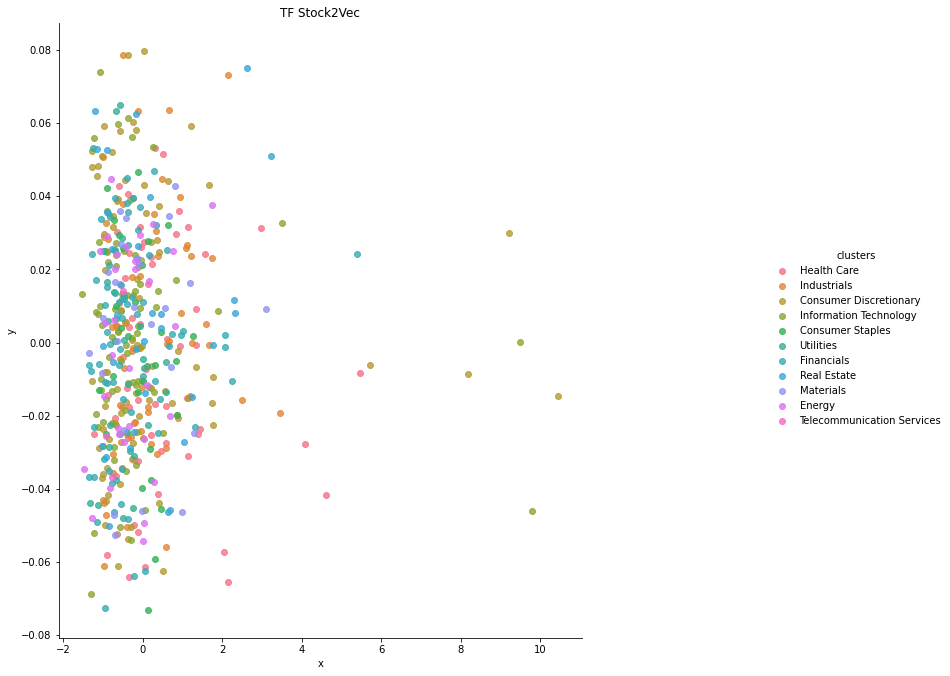

In [0]:
# plot embedding using PCA 2 components
pca_reduction(features=sotcks_tf_embeddings, labels_values=sotcks_sectors_ids, n_components=2, random_state=20, 
                  label_decoder=idx_sector, title='TF Stock2Vec', magnify=2);

# Gensim Word Embeddings

## Prep Data

For each date in out dataset we rearrange each company in ascending order based on the **change in price**.

Formula for **change in price** [source](https://pocketsense.com/calculate-market-price-change-common-stock-4829.html):
* (closing_price - opening_price) / opening_price

We can change the formula to use highest price and lowest price. This si something we will test out.

In [0]:
# stocks details read again without date format
stocks_df = pd.read_csv('/content/stocks_data/all_stocks_5yr.csv')

# get all companies symbols
symbols = stocks_df['Name'].values
dates = set(stocks_df['date'].values)
dates = sorted(dates)

# store each individual date and all it's stocks
dates_dictionary = {date:{} for date in dates}

# calculate price change for each stock and sort them in each day
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
# sort each day reverse order
dates_dictionary = {date:sort_dict(dates_dictionary[date]) for date in dates}

# data used for embeddings
stocks_w2v_data = [[value[0] for value in dates_dictionary[date]] for date in dates]

# print sample
print(stocks_w2v_data[0])

['MCO', 'MNST', 'SPGI', 'JNPR', 'AAL', 'BBY', 'INTU', 'SRCL', 'SCHW', 'MCHP', 'FLR', 'CL', 'ILMN', 'PVH', 'FB', 'M', 'IRM', 'VAR', 'DAL', 'BA', 'IT', 'BAC', 'EXC', 'ETR', 'XRX', 'O', 'LEN', 'LB', 'KLAC', 'PWR', 'RJF', 'HUM', 'C', 'VFC', 'EL', 'GLW', 'DHI', 'NEM', 'AEE', 'RMD', 'PG', 'RHT', 'RHI', 'MAS', 'EFX', 'DPS', 'IVZ', 'KSU', 'AES', 'NFLX', 'AXP', 'SIG', 'MU', 'TDG', 'RF', 'HIG', 'FDX', 'VZ', 'IDXX', 'PNC', 'T', 'LUK', 'ABBV', 'TRV', 'DVA', 'KMI', 'CTSH', 'CRM', 'FCX', 'ADM', 'PFE', 'CTAS', 'AMG', 'EQT', 'CCL', 'DGX', 'AKAM', 'NEE', 'GT', 'PEP', 'GPS', 'HCA', 'KO', 'NFX', 'COF', 'PDCO', 'BF.B', 'LEG', 'MET', 'SWK', 'NLSN', 'HRS', 'MDLZ', 'ARE', 'PEG', 'HP', 'CMS', 'ICE', 'DRI', 'MYL', 'SO', 'KMB', 'AJG', 'GRMN', 'DFS', 'BBT', 'CLX', 'PAYX', 'AFL', 'ETN', 'MKC', 'CSCO', 'NRG', 'ANSS', 'UAA', 'NI', 'KORS', 'K', 'TIF', 'UTX', 'BRK.B', 'DLR', 'F', 'GE', 'NVDA', 'NWL', 'EMR', 'A', 'ES', 'AIZ', 'PPL', 'NKE', 'JEC', 'AEP', 'DTE', 'SEE', 'ED', 'ABT', 'WY', 'HSIC', 'WU', 'PCG', 'RTN', 'QCO

## Find Best Model

Parameters used: 

* **sentences** – The sentences iterable can be simply a list of lists of tokens.

* **size** (int, optional) – Dimensionality of the word vectors.

* **window** (int, optional) – Maximum distance between the current and predicted word within a sentence.

* **min_count** (int, optional) – Ignores all words with total frequency lower than this.

* **sg** ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.

* **cbow_mean** ({0, 1}, optional) – If 0, use the sum of the context word vectors. If 1, use the mean, only applies when cbow is used.



Embedding size: 10 Algorithm: Skip-Gram


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


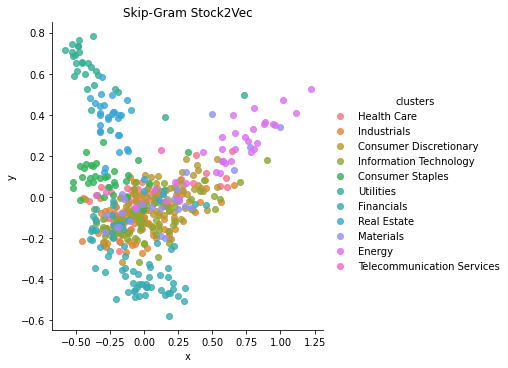

Embedding size: 10 Algorithm: CBOW


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


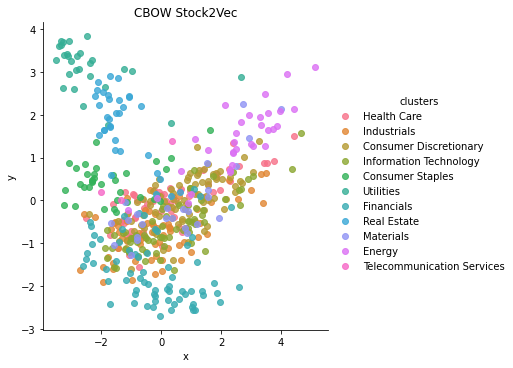

Embedding size: 50 Algorithm: Skip-Gram


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


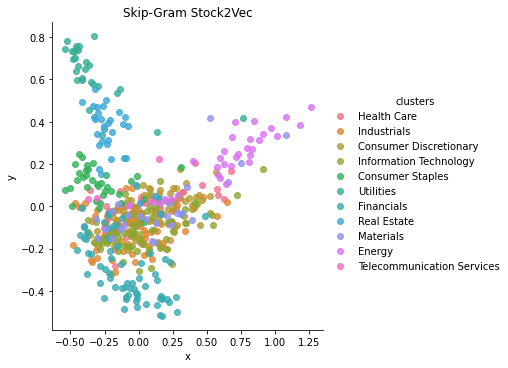

Embedding size: 50 Algorithm: CBOW


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


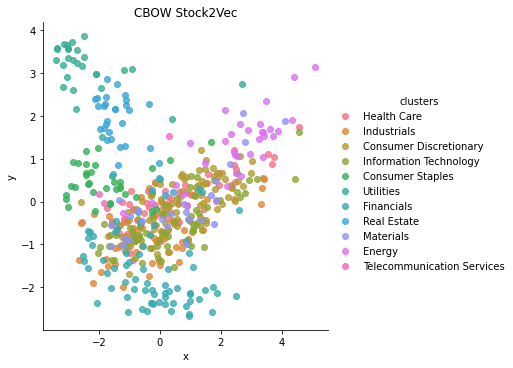

Embedding size: 100 Algorithm: Skip-Gram


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


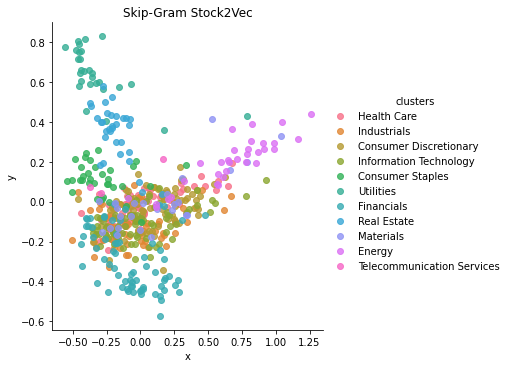

Embedding size: 100 Algorithm: CBOW


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


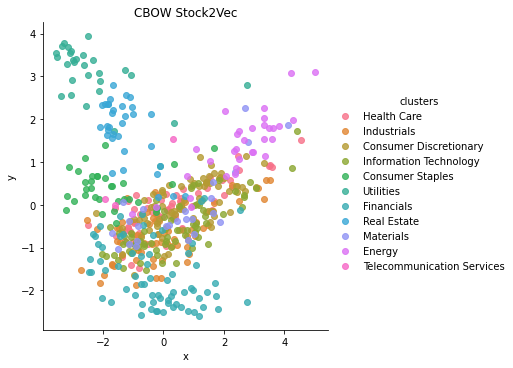

In [0]:
embeddings_sizes = [10, 50, 100]
algorithms = {'Skip-Gram':1,
              'CBOW':0}
cbow_flags = {'sum_context_word':0,
             'mean_context_word':1}

for embedding_size in embeddings_sizes:
  for algorithm_name, algorithm_flag in algorithms.items():
    if algorithm_name == 'cbow':
      for cbow_flag_name, cbow_flag in cbow_flags.items():
        print('Embedding size: %s Algorithm: %s CBOW: %s' % (embedding_size, algorithm_name, cbow_flag_name))
        # fit model
        tmp_model = Word2Vec(sentences=stocks_w2v_data, 
                             size=embedding_size, 
                             window=5, 
                             min_count=1, 
                             sg=algorithm_flag, 
                             hs=1, 
                             cbow_mean=cbow_flag)
        # get embeddings
        sotcks_gs_embeddings = tmp_model[stockid_encoder.classes_]
        # plot embedding using PCA 2 components
        pca_reduction(features=sotcks_gs_embeddings, labels_values=sotcks_sectors_ids, n_components=2, random_state=20, 
                      label_decoder=idx_sector, title='%s Stock2Vec'%algorithm_name, magnify=1);
        # clean for next itteration
        del tmp_model, sotcks_gs_embeddings
        gc.collect()
    else:
      print('Embedding size: %s Algorithm: %s' % (embedding_size, algorithm_name))
      tmp_model = Word2Vec(sentences=stocks_w2v_data, 
                            size=embedding_size, 
                            window=5, 
                            min_count=1, 
                            sg=algorithm_flag, 
                            hs=1)
      # get embeddings
      sotcks_gs_embeddings = tmp_model[stockid_encoder.classes_]
      # plot embedding using PCA 2 components
      pca_reduction(features=sotcks_gs_embeddings, labels_values=sotcks_sectors_ids, n_components=2, random_state=20, 
                    label_decoder=idx_sector, title='%s Stock2Vec'%algorithm_name, magnify=1);

      # clean for next itteration
      del tmp_model, sotcks_gs_embeddings
      gc.collect()


## Final Results

Using human judgement just by looking at the plots we found the best model we could use:

We realized that using the most basic parameters it gives good embeddings.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


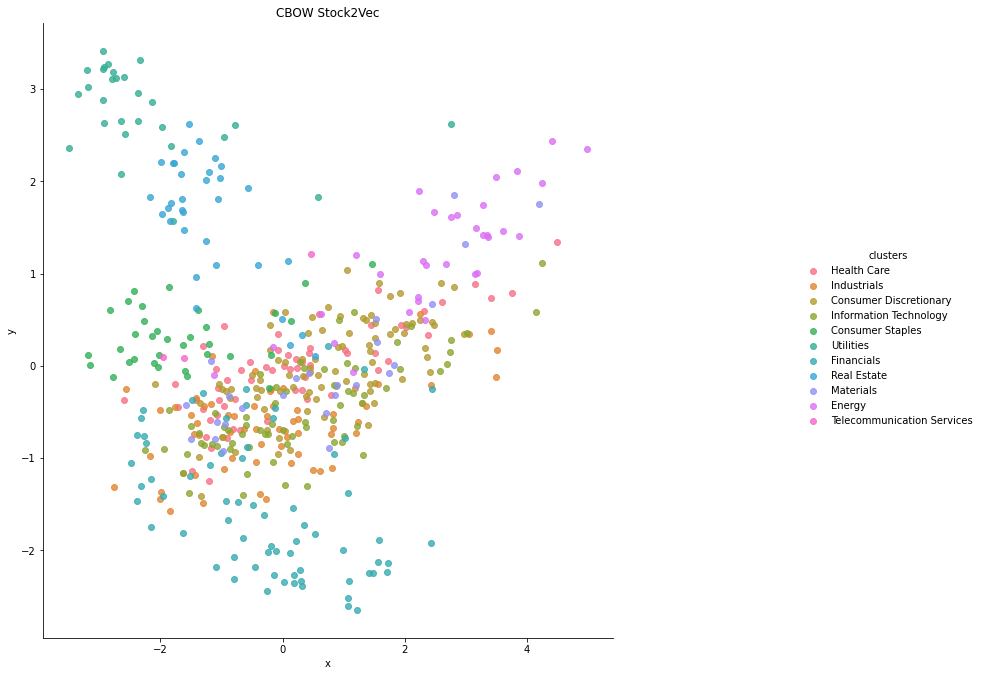

In [0]:
# model = Word2Vec(sentences=stocks_w2v_data, 
#                 size=10, 
#                 window=5, 
#                 min_count=1, 
#                 sg=1, 
#                 hs=0,
#                 negative=1)

model = Word2Vec(stocks_w2v_data, min_count=1)

# get embeddings
sotcks_gs_embeddings = model[stockid_encoder.classes_]

# plot embedding using PCA 2 components
pca_reduction(features=sotcks_gs_embeddings, labels_values=sotcks_sectors_ids, n_components=2, random_state=20, 
                  label_decoder=idx_sector, title='CBOW Stock2Vec', magnify=2);

## Example of most similar

In [0]:
target_symb = 'ALXN'
print('Symbol: {:<8} Sector:{:<25} Name:{:>10}'.format(target_symb, companies_names[target_symb], companies_sector[target_symb]))
top_similar = model.similar_by_word(target_symb, topn=20)
print('\nMost Similar')
for similar in top_similar:
  symb = similar[0]
  name = companies_names[symb]
  sect = companies_sector[symb]
  print('Symbol: {:<8} Sector:{:<25} Name:{:>10}'.format(symb, sect, name))

Symbol: ALXN     Sector:Alexion Pharmaceuticals   Name:Health Care

Most Similar
Symbol: REGN     Sector:Health Care               Name: Regeneron
Symbol: VRTX     Sector:Health Care               Name:Vertex Pharmaceuticals Inc
Symbol: INCY     Sector:Health Care               Name:    Incyte
Symbol: ILMN     Sector:Health Care               Name:Illumina Inc
Symbol: ALK      Sector:Industrials               Name:Alaska Air Group Inc
Symbol: MYL      Sector:Health Care               Name:Mylan N.V.
Symbol: BIIB     Sector:Health Care               Name:Biogen Inc.
Symbol: CNC      Sector:Health Care               Name:Centene Corporation
Symbol: UAA      Sector:Consumer Discretionary    Name:Under Armour Class A
Symbol: AAL      Sector:Industrials               Name:American Airlines Group
Symbol: CELG     Sector:Health Care               Name:Celgene Corp.
Symbol: NFLX     Sector:Information Technology    Name:Netflix Inc.
Symbol: UAL      Sector:Industrials               Name:United

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# Conclusions
 
 
#### - We came up with a new way to train stock2vec not know to be done elsewhere using Tensorflow and concatenating stock embeddings with regular stock features extracted from stock opening date. This model was trained to predict closing price of a stock and updating the embedding weights in the process. We used a small grid search across multiple parameters to find out the best suited parameters.
 
 
#### - Stock2Vec can be a very powerful tool in interpreting stocks. 
 
 
#### - We proved how we can use Natural Language Processing algorithms like `Word Embeddings` on stocks data.
 
 
#### - Provided enough visualization of stock embeddings to determine the quality of such embeddings.
 
 
#### - Stock embeddings obtained with most popular algorithms `SKIP-GRAM` and `CBOW` proved to be more effective than our Tensorflow embedding model.
 
 
#### - The best model that we've got for stock2vec is `CBOW`.
 